In [1]:
import sys; sys.path.insert(0, '..')
import os
import snappy_utils
import settings_BID
import utils
import math

from osgeo import gdal
from osgeo import osr

import matplotlib.pyplot as plt
import cv2
import numpy as np

### Define paths to Level-1C and Level-2A products

In [2]:
L1C_path = "data\\2020-03-23\\S2A_MSIL1C_20200323T133221_N0209_R081_T21HXB_20200323T182053.SAFE"
L2A_path = "data\\2020-03-23\\S2A_MSIL2A_20200323T133221_N0214_R081_T21HXB_20200323T185235.SAFE"

laguna_L1C_dim_path = os.path.join(settings_BID.data_path, "laguna-L1C.dim")
laguna_L2A_dim_path = os.path.join(settings_BID.data_path, "laguna-L2A.dim")

### Read Level-1C product, make subset and save as BEAM-DIMAP

In [3]:
# product = snappy_utils.read_product(L1C_path)
# subset = snappy_utils.make_subset(product, settings_BID.footprint)
# snappy_utils.write_product(subset, laguna_L1C_dim_path, "BEAM-DIMAP")
#snappy_utils.write_product(subset, os.path.join(settings.data_path, "laguna-L1C.tif"), "GeoTiff")

### Read Level-2A product, make subset and save as BEAM-DIMAP

In [4]:
# product = snappy_utils.read_product(L2A_path)
# subset = snappy_utils.make_subset(product, settings_BID.footprint)
# snappy_utils.write_product(subset, laguna_L2A_dim_path, "BEAM-DIMAP")
#snappy_utils.write_product(subset, os.path.join(settings.data_path, "laguna-L2A.tif"), "GeoTiff")

### Read Level-2A subset, get RGB bands, get red-edge band, plot data

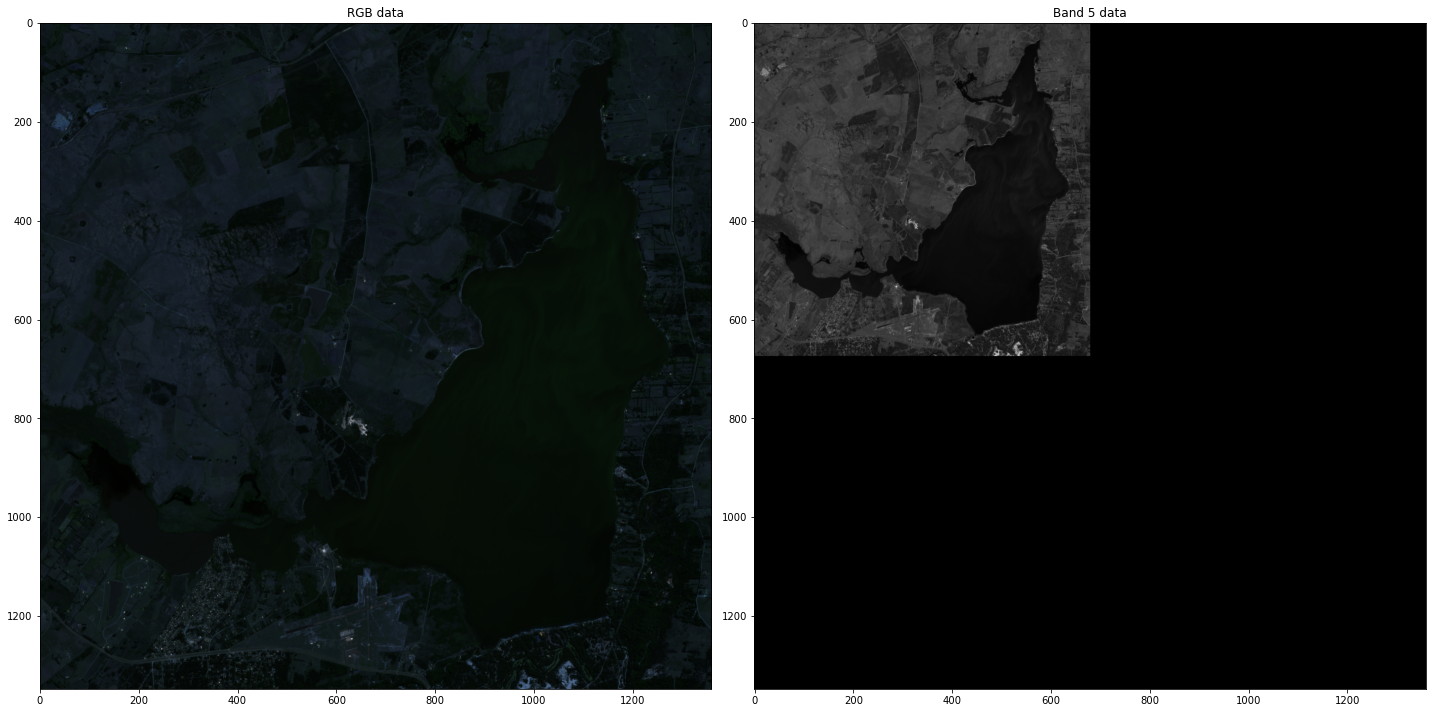

In [5]:
laguna_L2A = snappy_utils.read_product(laguna_L2A_dim_path)
bands = snappy_utils.get_bands(laguna_L2A, ["B2", "B3", "B4", "B5"])
fig = plt.figure(figsize=(20,10))

rgb_array = np.zeros((bands["B2"].shape[0], bands["B2"].shape[1], 3), dtype=np.uint8)
rgb_array[:, :, 0] = utils.stretch_to_MinMax(bands["B2"], verbose=False)
rgb_array[:, :, 1] = utils.stretch_to_MinMax(bands["B3"], verbose=False)
rgb_array[:, :, 2] = utils.stretch_to_MinMax(bands["B4"], verbose=False)

band5_image = np.zeros((bands["B5"].shape[0], bands["B5"].shape[1], 3), dtype=np.uint8)
band5_image[:, :, 0] = utils.stretch_to_MinMax(bands["B5"], verbose=False)
band5_image[:, :, 1] = utils.stretch_to_MinMax(bands["B5"], verbose=False)
band5_image[:, :, 2] = utils.stretch_to_MinMax(bands["B5"], verbose=False)

fig.add_subplot(121).title.set_text("RGB data")
plt.imshow(rgb_array)

fig.add_subplot(122).title.set_text("Band 5 data")
plt.imshow(band5_image, cmap="gray")

fig.tight_layout()

### Fix Band 5 resolution mismatch

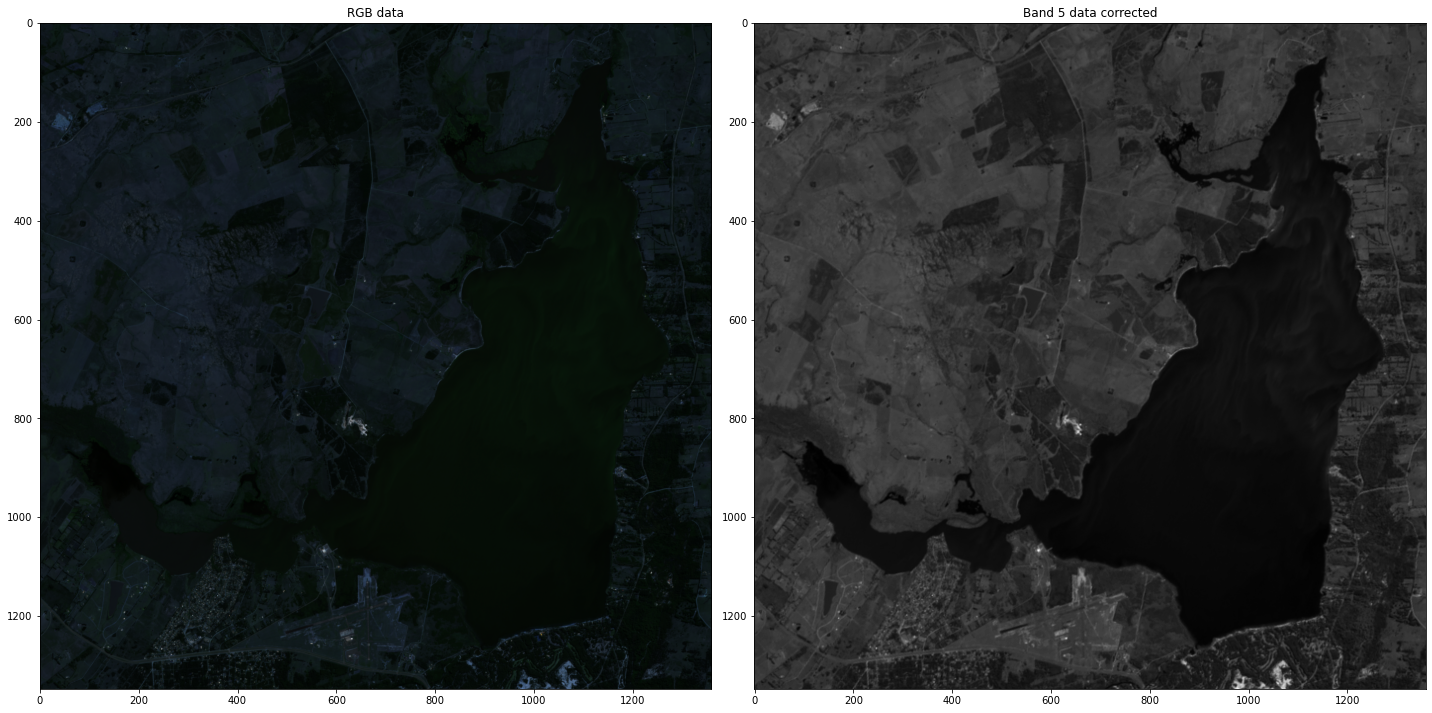

In [23]:
def match_20mto10m_resolution(array_20m):
    # create empty array to store corrected data
    fixed_array = np.zeros((array_20m.shape[0], array_20m.shape[1]), dtype=np.float32)
    # find max index for x and y with data
    max_x = -1
    max_y = -1
    for y, row in enumerate(array_20m):
        for x, val in enumerate(row):
            if y == 0 and val != 0:
                max_x += 1
            if x == 0 and val != 0:
                max_y += 1
                
    for y, row in enumerate(array_20m):
        for x, val in enumerate(row):
            if y <= max_y and x <= max_x:
                try:
                    fixed_array[2*y,2*x] = val
                    fixed_array[2*y+1,2*x] = val
                    fixed_array[2*y,2*x+1] = val
                    fixed_array[2*y+1,2*x+1] = val
                except IndexError:
                    #print("Index error at: {},{}".format(x,y))
                    pass
    return fixed_array
            

fig = plt.figure(figsize=(20,10))

fixed_band5 = match_20mto10m_resolution(bands["B5"])
# fixed_band5_image = np.zeros((fixed_band5.shape[0], fixed_band5.shape[1], 3), dtype=np.uint8)
# fixed_band5_image[:, :, 0] = utils.stretch_to_MinMax(fixed_band5, verbose=False)
# fixed_band5_image[:, :, 1] = utils.stretch_to_MinMax(fixed_band5, verbose=False)
# fixed_band5_image[:, :, 2] = utils.stretch_to_MinMax(fixed_band5, verbose=False)

fig.add_subplot(121).title.set_text("RGB data")
plt.imshow(rgb_array)

fig.add_subplot(122).title.set_text("Band 5 data corrected")
#plt.imshow(fixed_band5, cmap="gray", interpolation=None, vmin=np.amin(fixed_band5), vmax=np.amax(fixed_band5))
#plt.colorbar()
plt.imshow(fixed_band5, cmap="gray")


fig.tight_layout()

### Make NDCI array and plot it

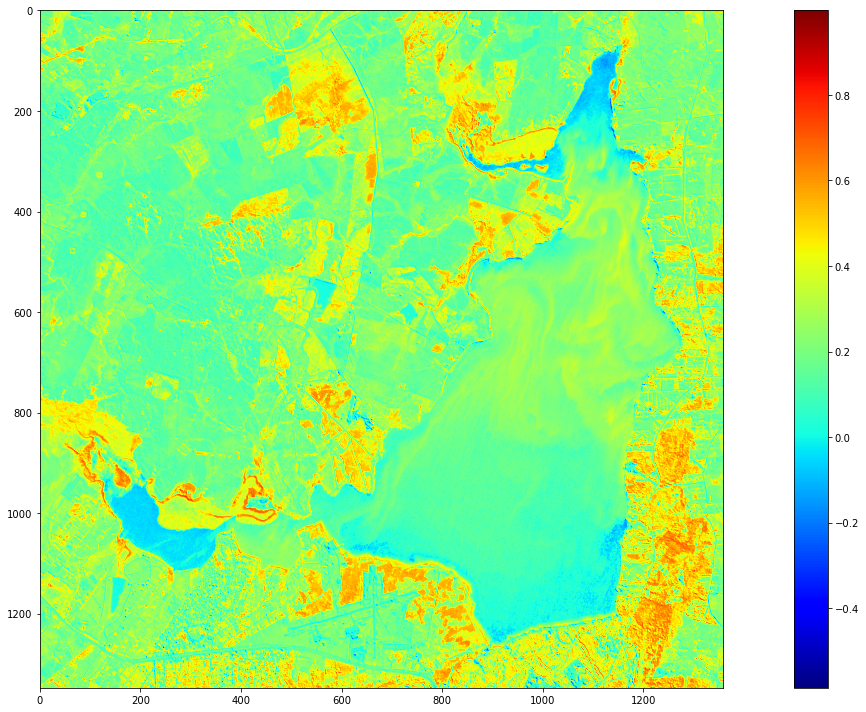

In [25]:
NDCI = (fixed_band5 - bands["B4"])/(fixed_band5 + bands["B4"])
fig = plt.figure(figsize=(20,10))
plt.imshow(NDCI, cmap="jet", interpolation=None, vmin=np.amin(NDCI), vmax=np.amax(NDCI))
plt.colorbar()
fig.tight_layout()

### Create GeoTiff for band 5

In [ ]:
# band 5 geotiff path
laguna_band5_geotiff_path = os.path.join(settings_BID.data_path, "laguna-band5.tif")

ds = gdal.Open(os.path.join(settings_BID.data_path, "laguna-L2A_RGB.tif"))

# set geotransform
nx = fixed_band5.shape[1]
ny = fixed_band5.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_band5_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(fixed_band5)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for NDCI

In [18]:
# band 5 geotiff path
laguna_NDCI_geotiff_path = os.path.join(settings_BID.data_path, "laguna-NDCI.tif")

ds = gdal.Open(os.path.join(settings_BID.data_path, "laguna-L2A_RGB.tif"))

# set geotransform
nx = NDCI.shape[1]
ny = NDCI.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_NDCI_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(NDCI)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None